<div style="background:#2e7d32; padding:40px; text-align:center; border-radius:10px;">
  <span style="font-size:48px; font-weight:bold; color:#ffffff; font-family:Arial;">
    connect with Drive
  </span>
</div>


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls "/content/drive/MyDrive/converted_unified"

data_cls.yaml  images  labels  YOLO_Training


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!ls "/content/drive/MyDrive/converted_unified"
!find "/content/drive/MyDrive/converted_unified/images/train" -type f | wc -l
!find "/content/drive/MyDrive/converted_unified/images/val" -type f | wc -l

!cat "/content/drive/MyDrive/converted_unified/data.yaml"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
data_cls.yaml  images  labels
10129
1135
cat: /content/drive/MyDrive/converted_unified/data.yaml: No such file or directory


<div style="background:#2e7d32; padding:40px; text-align:center; border-radius:10px;">
  <span style="font-size:48px; font-weight:bold; color:#ffffff; font-family:Arial;">
    Copy Data 
  </span>
</div>


In [ ]:
from pathlib import Path
import shutil

source = Path("/content/drive/MyDrive/converted_unified")
dest = Path("/content/data")

if dest.exists():
    shutil.rmtree(dest)

shutil.copytree(source, dest)
print("Done to /content/data ")
!ls /content/data

Done to /content/data 
data_cls.yaml  images  labels


<div style="background:#2e7d32; padding:40px; text-align:center; border-radius:10px;">
  <span style="font-size:48px; font-weight:bold; color:#ffffff; font-family:Arial;">
    Over sample Data
  </span>
</div>


In [ ]:
from pathlib import Path
import shutil
import random
from PIL import Image, ImageEnhance, ImageOps

ROOT = Path("/content/data")
IMG_TRAIN = ROOT / "images" / "train"
LBL_TRAIN = ROOT / "labels" / "train"

final_classes = ['arson', 'explosion', 'fighting', 'fire', 'handgun', 'knife', 'normal',
                 'rifle', 'road_accident', 'robbery', 'shooting', 'shoplifting', 'smoke', 'vandalism']
NORMAL_ID = final_classes.index("normal")

normal_images = []
for lbl_file in LBL_TRAIN.iterdir():
    if lbl_file.stat().st_size == 0:
        continue
    lines = lbl_file.read_text().splitlines()
    if any(line.split()[0] == str(NORMAL_ID) for line in lines if line.strip()):
        img_path = IMG_TRAIN / (lbl_file.stem + ".jpg")
        if not img_path.exists():
            img_path = IMG_TRAIN / (lbl_file.stem + ".png")
        if img_path.exists():
            normal_images.append((img_path, lbl_file))

print(f"num of image normal: {len(normal_images)}")

AUG_TARGET = 4000
added = 0
for i in range(AUG_TARGET):
    src_img, src_lbl = random.choice(normal_images)

    img = Image.open(src_img)

    if random.random() > 0.5: img = img.transpose(Image.FLIP_LEFT_RIGHT)
    if random.random() > 0.5: img = img.transpose(Image.FLIP_TOP_BOTTOM)
    if random.random() > 0.5: img = ImageEnhance.Brightness(img).enhance(random.uniform(0.7, 1.3))
    if random.random() > 0.5: img = img.rotate(random.uniform(-20, 20), expand=True, resample=Image.BICUBIC)

    new_name = src_img.stem + f"_aug_{added}{src_img.suffix}"
    new_img_path = IMG_TRAIN / new_name
    new_lbl_path = LBL_TRAIN / new_name.replace(src_img.suffix, ".txt")

    img.save(new_img_path)
    shutil.copy2(src_lbl, new_lbl_path)
    added += 1
    if added % 500 == 0:
        print(f"add done{added} image augmented")

print(f"done we add {added} normal")

yaml_content = """
path: /content/data
train: images/train
val: images/val
nc: 14
names: ['arson', 'explosion', 'fighting', 'fire', 'handgun', 'knife', 'normal', 'rifle', 'road_accident', 'robbery', 'shooting', 'shoplifting', 'smoke', 'vandalism']
"""
(ROOT / "data.yaml").write_text(yaml_content)
print("data.yaml update to /content/data")

num of image normal: 55
add done500 image augmented
add done1000 image augmented
add done1500 image augmented
add done2000 image augmented
add done2500 image augmented
add done3000 image augmented
add done3500 image augmented
add done4000 image augmented
done we add 4000 normal
data.yaml update to /content/data


<div style="background:#2e7d32; padding:40px; text-align:center; border-radius:10px;">
  <span style="font-size:48px; font-weight:bold; color:#ffffff; font-family:Arial;">
    Represent Random Images
  </span>
</div>


total normal after augmentation: 4055 


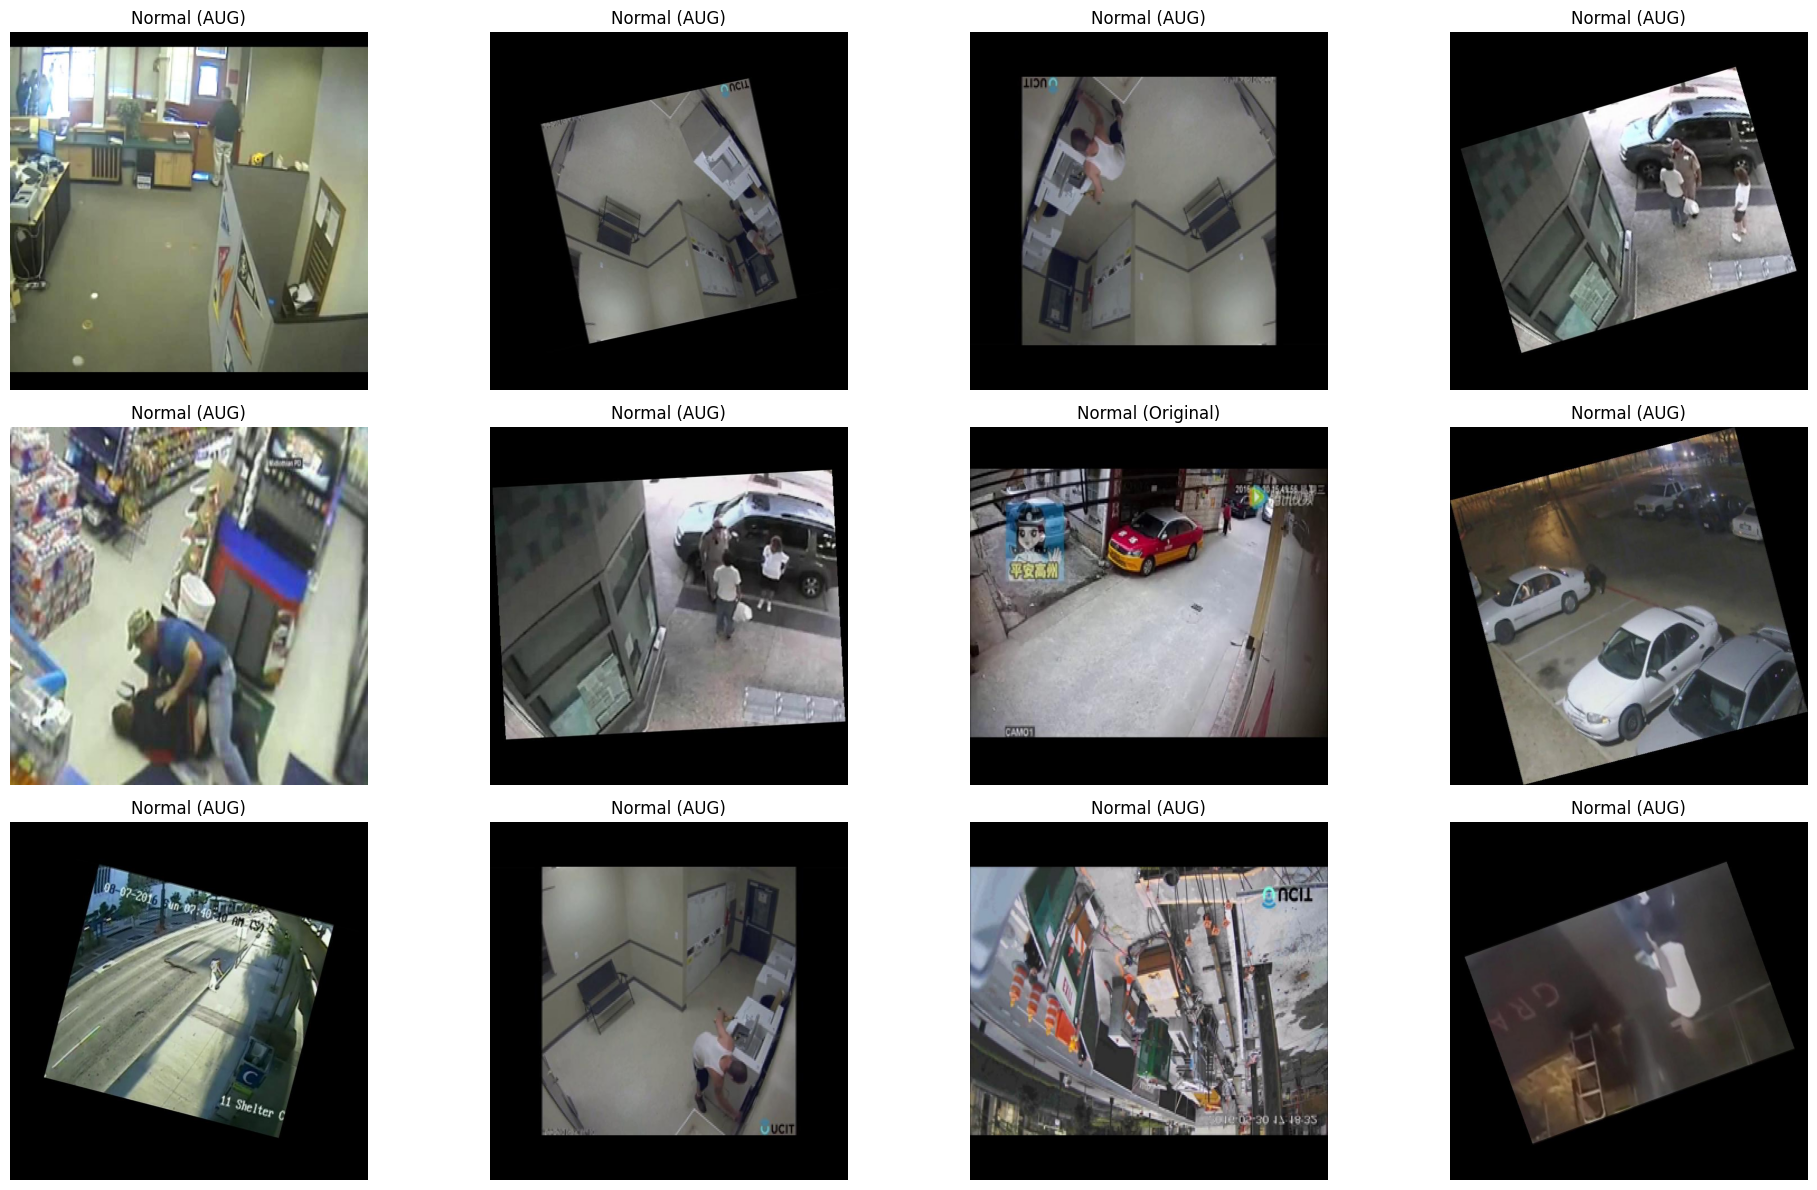

In [ ]:
import matplotlib.pyplot as plt
import random
from pathlib import Path

IMG_TRAIN = Path("/content/data/images/train")
LBL_TRAIN = Path("/content/data/labels/train")

final_classes = ['arson', 'explosion', 'fighting', 'fire', 'handgun', 'knife', 'normal',
                 'rifle', 'road_accident', 'robbery', 'shooting', 'shoplifting', 'smoke', 'vandalism']
NORMAL_ID = final_classes.index("normal")

normal_images = []
for lbl_file in LBL_TRAIN.iterdir():
    if lbl_file.suffix != ".txt": continue
    lines = lbl_file.read_text().splitlines()
    if any(line.split()[0] == str(NORMAL_ID) for line in lines if line.strip()):
        for ext in [".jpg", ".jpeg", ".png", ".bmp", ".webp"]:
            img_path = IMG_TRAIN / (lbl_file.stem + ext)
            if img_path.exists():
                normal_images.append(img_path)
                break

random.shuffle(normal_images)
samples = normal_images[:12]

print(f"total normal after augmentation: {len(normal_images)} ")

plt.figure(figsize=(20, 12))
for i, p in enumerate(samples):
    img = plt.imread(p)
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(f"Normal {'(AUG)' if 'aug' in p.name else '(Original)'}")
    plt.axis("off")
plt.tight_layout()
plt.show()